In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage import color, exposure, filters, io, morphology, util
from math import sqrt
from numpy import loadtxt
from tensorflow import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Reshape
from keras.optimizers import SGD

### TRANSFER LEARNING

#### 1.
Bangun sebuah model $\text{Convolutional Neural Network}$ dengan arsitektur dasar sebagai berikut :
- Convolutional Layer ($25$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Convolutional Layer ($50$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Convolutional Layer ($100$ maps, kernel $3 \times 3$)
- Pooling Layer ($2 \times 2$)
- Activation Function ($\text{ReLU function}$)
- Hidden Layer ($100$ neuron)
- Activation Function ($\text{ReLU function}$)
- Output Layer ($10$ kelas)
- Activation Function ($\text{Softmax function}$)
- Classification Result

Dengan tambahan beberapa seperti:
- Adam optimization
- Early Stop

##### Mendefinisikan Fungsi Bantuan
Untuk memudahkan implementasi, berikut beberapa fungsi bantuan yang akan dipakai

###### Menghitung $\text{recall}$ atau $\text{sensitivity}$
$$\text{recall} = \frac{t_p}{t_p+t_n}$$

In [2]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

###### Menghitung $\text{precision}$
$$\text{precision} = \frac{t_p}{t_p + f_p}$$

In [3]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

###### Menghitung $\text{specificity}$
$$\text{specificity} = \frac{t_n}{t_n + f_p}$$

In [4]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

###### Menghitung $f_{1}\text{ Score}$
Kita tau bahwa
$$f_{\beta} = (1 + \beta^{2}) \cdot \frac{\text{precision} \cdot \text{recall}}{(\beta^{2} \cdot \text{precision}) + \text{recall}}$$
Sehingga 
$$f_{1} = (1 + 1^{2}) \cdot \frac{\text{precision} \cdot \text{recall}}{(1^{2} \cdot \text{precision}) + \text{recall}}$$
$$f_{1} = (2) \cdot \frac{\text{precision} \cdot \text{recall}}{(\text{precision}) + \text{recall}}$$



In [5]:
def f1_score(y_true, y_pred):
    precision_val = precision(y_true, y_pred)
    recall_val = recall(y_true, y_pred)
    return 2*((precision_val * recall_val)/(precision_val + recall_val + K.epsilon()))

**n.b.: Semua fungsi pada bagian penyebut ditambah epsilon untuk menghindari dibagi $0$ dikarenakan memasukkan input sebanyak $0$**

###### Fungsi Bantuan untuk Melakukan Prediksi dan Menampilkan Metric

In [6]:
def predict_and_get_metrics(model, x_test, y_test, label):
    _, accuracy, sensitivity, specificity, score_f1 = model.evaluate(x_test, y_test, verbose=0)
    return pd.DataFrame([[accuracy, sensitivity, specificity, score_f1]], columns=['Accuracy', 'Sensitivity', 'Specificity', 'F1 Score'], index=[label])

def compare_train_and_test(model, x_train, y_train, x_test, y_test, extra_label=''):
    metric_train = predict_and_get_metrics(model, x_train, y_train, 'Data Train %s' % (extra_label))
    metric_test = predict_and_get_metrics(model, x_test, y_test, 'Data Test %s' % (extra_label))
    return pd.concat([metric_train, metric_test])

###### Fungsi Bantuan untuk _Load Dataset_

In [7]:
def load_dataset_cifar10():
	(trainX, trainY), (testX, testY) = keras.datasets.cifar10.load_data()
	return np.concatenate((trainX, testX), axis=0), np.concatenate((trainY, testY), axis=0)
 
def load_dataset_cifar100():
	(trainX, trainY), (testX, testY) = keras.datasets.cifar100.load_data()
	return np.concatenate((trainX, testX), axis=0), np.concatenate((trainY, testY), axis=0)

##### Load Dataset

In [8]:
x, y = load_dataset_cifar10()
x.shape

170500096/170498071 [==============================] - 11s 0us/step


(60000, 32, 32, 3)

##### Mengambil Dataset Sebanyak 1000 Per Kelasnya

In [9]:
idx_sample = np.array([],dtype=int)

for i in range(10):
    idx = (y == i).reshape(x.shape[0])
    idx_data = np.where(idx == True)
    sampled_list = np.random.choice(idx_data[0], size=1000, replace=False)
    idx_sample = np.concatenate((idx_sample, sampled_list), axis=0)

##### Melakukan Validasi Apakah Shape-nya Sudah Valid atau Belum

In [10]:
x_sample = x[idx_sample]
y_sample = y[idx_sample]
x_sample.shape, y_sample.shape

((10000, 32, 32, 3), (10000, 1))

##### Melakukan Normalisasi untuk $x$

In [11]:
def normalize(x):
    return x / 255.0

x_sample = normalize(x_sample)

##### Merubah Menjadi Matrix Binary untuk $y$

In [12]:
y_sample = tf.keras.utils.to_categorical(y_sample)

##### Memecah Menjadi 60 : 40 ~ Train : Test

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_sample, y_sample, test_size=0.4)

##### Membangun Model Convolutional Neural Network

In [14]:
def create_model(learning_rate, pre_defined_layers=[]):
    convolutional_layers = []
    if len(pre_defined_layers) == 0:
        ## Convolutional Layers 25 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(25, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        ## Convolutional Layers 50 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(50, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        ## Convolutional Layers 100 map, 3 x 3, activation = relu
        convolutional_layers.append(Conv2D(100, kernel_size=(3, 3), activation=tf.nn.relu, padding='SAME', kernel_initializer=tf.keras.initializers.HeUniform()))

        ## Pooling Layer 2 x 2
        convolutional_layers.append(MaxPooling2D(2,2))

        convolutional_layers.append(Flatten())

        ## Hidden Layer 100 node
        convolutional_layers.append(Dense(100, activation=tf.nn.relu))

        ## Output 10 class
        convolutional_layers.append(Dense(10, activation=tf.nn.softmax))
    else:
        convolutional_layers = pre_defined_layers

    ## Menginisialisasi instance model
    convolutional_model = Sequential(convolutional_layers)

    ## Membangun model
    convolutional_model.build(input_shape=x_train.shape)

    ## Melakukan Kompilasi ke dalam Model
    convolutional_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='categorical_crossentropy',
    metrics=[
      'accuracy',
      recall,
      specificity,
      f1_score
    ])

    return convolutional_model

##### Melakukan _fitting_ dengan $\text{epochs} = 100$, $\text{batch_size} = 10$, dan $\text{learning_rate} = 0.1$, dan $\text{Early Stopping}$

In [15]:
## Mendefinisikan Early Stopping untuk Semua Model CNN Awal
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [16]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 16s 27ms/step - loss: 32.2318 - accuracy: 0.0957 - recall: 6.6667e-04 - specificity: 0.9993 - f1_score: 6.6667e-04 - val_loss: 2.3136 - val_accuracy: 0.1055 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 16s 27ms/step - loss: 2.3299 - accuracy: 0.0985 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3191 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


#### 3.
Lakukan skenario eksperimen untuk mendapatkan metrik evaluasi optimal ($\text{akurasi}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1} \text{ score}$) dengan mengubah parameter yaitu:
1. Mengubah epoch, dengan $\text{learning_rate} = 0.1$ dan $\text
{batch_number} = 10$.
2. Mengubah jumlah $\text{batch number}$ dengan $\text{epoch}$ optimal dari skenario (1) dan $\text{learning_rate} = 0.1$.
3. Mengubah $\text{learning_rate}$ dengan $\text{epoch}$ optimal dari skenario (1) dan jumlah $\text{batch_number}$ optimal dari skenario (2).

##### Melakukan Skenario 3.1. (Mengubah $\text{epoch}$)

###### Skenario 3.1.1. ($\text{epoch} = 100$)

In [17]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 16s 27ms/step - loss: 32.1379 - accuracy: 0.0972 - recall: 0.0015 - specificity: 0.9991 - f1_score: 0.0015 - val_loss: 2.3179 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 16s 27ms/step - loss: 2.3264 - accuracy: 0.0975 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3111 - val_accuracy: 0.1070 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
600/600 [==============================] - 16s 27ms/step - loss: 2.3248 - accuracy: 0.1002 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3313 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario 3.1.2. ($\text{epoch} = 50$)

In [18]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=50, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/50
600/600 [==============================] - 19s 31ms/step - loss: 7.7161 - accuracy: 0.0992 - recall: 5.0000e-04 - specificity: 0.9996 - f1_score: 5.0000e-04 - val_loss: 2.3373 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/50
600/600 [==============================] - 17s 28ms/step - loss: 2.3289 - accuracy: 0.0935 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3260 - val_accuracy: 0.0985 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/50
600/600 [==============================] - 16s 27ms/step - loss: 2.3253 - accuracy: 0.1017 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3215 - val_accuracy: 0.1070 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/50
600/600 [==============================] - 16s 27ms/step - loss: 2.3261 - accuracy: 0.1020 - recall: 0.0000e+00 - specificity

###### Skenario 3.1.3. ($\text{epoch}$ = 25)

In [19]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=25, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/25
600/600 [==============================] - 18s 30ms/step - loss: 17.2212 - accuracy: 0.1007 - recall: 6.6667e-04 - specificity: 0.9997 - f1_score: 6.6667e-04 - val_loss: 2.3390 - val_accuracy: 0.0985 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/25
600/600 [==============================] - 18s 30ms/step - loss: 2.3244 - accuracy: 0.1047 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3119 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/25
600/600 [==============================] - 19s 31ms/step - loss: 2.3276 - accuracy: 0.1027 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3191 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario 3.1.4. ($\text{epoch}$ = 10)

In [20]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=10, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/10
600/600 [==============================] - 17s 29ms/step - loss: 39.9658 - accuracy: 0.0957 - recall: 3.3333e-04 - specificity: 0.9992 - f1_score: 3.3333e-04 - val_loss: 2.3241 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/10
600/600 [==============================] - 17s 28ms/step - loss: 2.3248 - accuracy: 0.0962 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3251 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario 3.1.5. ($\text{epoch} = 5$)



In [21]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=5, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/5
600/600 [==============================] - 17s 28ms/step - loss: 26.4503 - accuracy: 0.0945 - recall: 0.0012 - specificity: 0.9980 - f1_score: 0.0012 - val_loss: 2.3162 - val_accuracy: 0.1055 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/5
600/600 [==============================] - 17s 28ms/step - loss: 2.3200 - accuracy: 0.1068 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3487 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Kesimpulan Skenario $3.1.$

Berdasarkan hasil dari skenario $3.1.1.$, $3.1.2.$, $3.1.3.$, $3.1.4.$, dan $3.1.5.$, kelima skenario mengalami _early stop_ pada $\text{epoch} \leq 5$. Kelima skenario menghasilkan akurasi yang rendah pula, dengan demikian, digunakan $\text{epoch}$ terbesar ($\text{epoch} = 100$) dikarenakan sudah ada penjaga _early stop_ untuk mengecek ke _convergen_-an.

##### Melakukan Skenario $3.2.$ (Mengubah $\text{batch_number}$)

###### Skenario $3.2.1.$ ($\text{batch_number} = 10$)

In [22]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=10, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
600/600 [==============================] - 16s 27ms/step - loss: 12.4048 - accuracy: 0.0967 - recall: 8.3333e-04 - specificity: 0.9992 - f1_score: 8.3333e-04 - val_loss: 2.3358 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
600/600 [==============================] - 16s 27ms/step - loss: 2.3257 - accuracy: 0.1053 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3442 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.2.2.$ ($\text{batch_number} = 25$)

In [23]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=25, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
240/240 [==============================] - 14s 57ms/step - loss: 48.9598 - accuracy: 0.0993 - recall: 0.0023 - specificity: 0.9984 - f1_score: 0.0024 - val_loss: 2.3298 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
240/240 [==============================] - 13s 56ms/step - loss: 2.3154 - accuracy: 0.0957 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3136 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
240/240 [==============================] - 13s 56ms/step - loss: 2.3140 - accuracy: 0.1010 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3234 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.3.$ ($\text{batch_number} = 50$)

In [24]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=50, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
120/120 [==============================] - 13s 106ms/step - loss: 126.7917 - accuracy: 0.0967 - recall: 0.0028 - specificity: 0.9969 - f1_score: 0.0032 - val_loss: 2.3175 - val_accuracy: 0.1070 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
120/120 [==============================] - 13s 105ms/step - loss: 2.3100 - accuracy: 0.0957 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3137 - val_accuracy: 0.1035 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
120/120 [==============================] - 13s 104ms/step - loss: 2.3113 - accuracy: 0.1012 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3127 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
120/120 [==============================] - 14s 115ms/step - loss: 2.3119 - accuracy: 0.0990 - recall: 0.0000e+00 - specifici

###### Skenario $3.2.4.$ ($\text{batch_number} = 75$)

In [25]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 154ms/step - loss: 204.4709 - accuracy: 0.0990 - recall: 0.0042 - specificity: 0.9947 - f1_score: 0.0044 - val_loss: 2.3115 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 147ms/step - loss: 2.3102 - accuracy: 0.0948 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3107 - val_accuracy: 0.0993 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 12s 148ms/step - loss: 2.3103 - accuracy: 0.0990 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3068 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 12s 147ms/step - loss: 2.3089 - accuracy: 0.0978 - recall: 0.0000e+00 - specificity: 1.00

###### Skenario $3.2.5.$ ($\text{batch_number} = 100$)

In [26]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=100, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
60/60 [==============================] - 12s 197ms/step - loss: 111.5377 - accuracy: 0.0987 - recall: 0.0058 - specificity: 0.9962 - f1_score: 0.0065 - val_loss: 2.3121 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
60/60 [==============================] - 12s 194ms/step - loss: 2.3077 - accuracy: 0.1035 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3076 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
60/60 [==============================] - 12s 194ms/step - loss: 2.3080 - accuracy: 0.0973 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3118 - val_accuracy: 0.0975 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.6.$ ($\text{batch_number} = 250$)

In [27]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=250, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
24/24 [==============================] - 11s 461ms/step - loss: 378.4659 - accuracy: 0.0955 - recall: 0.0113 - specificity: 0.9874 - f1_score: 0.0113 - val_loss: 2.3064 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
24/24 [==============================] - 11s 448ms/step - loss: 2.3090 - accuracy: 0.0987 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3041 - val_accuracy: 0.0993 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
24/24 [==============================] - 11s 448ms/step - loss: 2.3082 - accuracy: 0.0988 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3087 - val_accuracy: 0.1035 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00003: early stopping


###### Skenario $3.2.7.$ ($\text{batch_number} = 500$)

In [28]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=500, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
12/12 [==============================] - 11s 877ms/step - loss: 538.6183 - accuracy: 0.0958 - recall: 0.0197 - specificity: 0.9804 - f1_score: 0.0214 - val_loss: 2.3223 - val_accuracy: 0.0978 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
12/12 [==============================] - 10s 860ms/step - loss: 2.3136 - accuracy: 0.0938 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3054 - val_accuracy: 0.0985 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
12/12 [==============================] - 10s 862ms/step - loss: 2.3039 - accuracy: 0.0992 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3053 - val_accuracy: 0.1035 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
12/12 [==============================] - 10s 857ms/step - loss: 2.3049 - accuracy: 0.0933 - recall: 0.0000e+00 - specificity: 1.00

###### Skenario $3.2.8.$ ($\text{batch_number} = 750$)

In [29]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=750, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
8/8 [==============================] - 10s 1s/step - loss: 520.3365 - accuracy: 0.0917 - recall: 0.0247 - specificity: 0.9743 - f1_score: 0.0248 - val_loss: 2.3651 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
8/8 [==============================] - 10s 1s/step - loss: 2.3425 - accuracy: 0.1013 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3155 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
8/8 [==============================] - 10s 1s/step - loss: 2.3099 - accuracy: 0.1033 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3057 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
8/8 [==============================] - 10s 1s/step - loss: 2.3067 - accuracy: 0.1003 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.000

###### Skenario $3.2.9.$ ($\text{batch_number} = 1000$)

In [30]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=1000, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
6/6 [==============================] - 10s 2s/step - loss: 205.1836 - accuracy: 0.0982 - recall: 0.0650 - specificity: 0.9324 - f1_score: 0.0657 - val_loss: 11.8513 - val_accuracy: 0.0975 - val_recall: 0.0975 - val_specificity: 0.8997 - val_f1_score: 0.0975
Epoch 2/100
6/6 [==============================] - 10s 2s/step - loss: 4.9261 - accuracy: 0.1008 - recall: 0.0350 - specificity: 0.9698 - f1_score: 0.0425 - val_loss: 2.3778 - val_accuracy: 0.0985 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 9s 2s/step - loss: 2.3626 - accuracy: 0.1010 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3459 - val_accuracy: 0.0985 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 9s 2s/step - loss: 2.3345 - accuracy: 0.1010 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss:

###### Skenario $3.2.10.$ ($\text{batch_number} = |\text{data_train}|$)

In [31]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=len(x_train), validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 2.5930 - accuracy: 0.1075 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 4837.8730 - val_accuracy: 0.1055 - val_recall: 0.1055 - val_specificity: 0.9006 - val_f1_score: 0.1055
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 4837.3042 - accuracy: 0.0963 - recall: 0.0963 - specificity: 0.8996 - f1_score: 0.0963 - val_loss: 39.1218 - val_accuracy: 0.1070 - val_recall: 0.1070 - val_specificity: 0.9008 - val_f1_score: 0.1070
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 38.3197 - accuracy: 0.0953 - recall: 0.0953 - specificity: 0.8995 - f1_score: 0.0953 - val_loss: 2.3714 - val_accuracy: 0.0975 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 2.3595 - accuracy: 0.1017 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.36

###### Kesimpulan Skenario $3.2.$

Berdasarkan hasil dari skenario $3.2.1.$, $3.2.2.$, $3.2.3.$, $3.2.4.$, $3.2.5.$, $3.2.6.$, $3.2.7.$, $3.2.8.$, $3.2.9.$, dan $3.2.10.$, kesepuluh skenario mengalami _early stop_ pada $\text{epoch} \leq 10$. Semua skenario memiliki nilai akurasi yang rendah (sekitar $\pm 10\%$). Sulit untuk menentukan parameter optimal dari kelima skenario dengan urutan pengambilan skenario dari $\text{batch_size}$ terlebih dahulu ketimbang $\text{learning_rate}$. Untuk keberlanjutan skenario, penentuan $\text{batch_size}$ digunakan pendekatan $\text{batch_size} \geq \sqrt{|sampel|} = \sqrt{10000 \cdot 0,6} \approx 77$. Nilai $\text{batch_size}$ yang mendekati dari skenario tersebut adalah nilai $\text{batch_size}$ pada skenario $3.2.4.$ yaitu $75$.

##### Melakukan Skenario $3.3.$ (Mengubah $\text{learning_rate}$)

###### Skenario $3.3.1.$ ($\text{learning_rate} = 0.25$)

In [32]:
convolutional_model = create_model(0.25)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 147ms/step - loss: 10590.9766 - accuracy: 0.1023 - recall: 0.0040 - specificity: 0.9963 - f1_score: 0.0040 - val_loss: 2.3108 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 145ms/step - loss: 2.3208 - accuracy: 0.1028 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3338 - val_accuracy: 0.0993 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.3.2.$ ($\text{learning_rate} = 0.1$)

In [33]:
convolutional_model = create_model(0.1)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 150ms/step - loss: 86.2325 - accuracy: 0.0985 - recall: 0.0047 - specificity: 0.9949 - f1_score: 0.0048 - val_loss: 2.3077 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 147ms/step - loss: 2.3323 - accuracy: 0.1005 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3141 - val_accuracy: 0.0995 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 00002: early stopping


###### Skenario $3.3.3.$ ($\text{learning_rate} = 0.05$)

In [34]:
convolutional_model = create_model(0.05)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 151ms/step - loss: 26.4783 - accuracy: 0.1043 - recall: 0.0042 - specificity: 0.9971 - f1_score: 0.0062 - val_loss: 2.3102 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 12s 147ms/step - loss: 2.3060 - accuracy: 0.1007 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3079 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 3/100
80/80 [==============================] - 12s 146ms/step - loss: 2.3062 - accuracy: 0.1062 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.3055 - val_accuracy: 0.0957 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 4/100
80/80 [==============================] - 12s 148ms/step - loss: 2.3061 - accuracy: 0.1020 - recall: 0.0000e+00 - specificity: 1.000

###### Skenario $3.3.4.$ ($\text{learning_rate} = 0.01$)

In [35]:
convolutional_model = create_model(0.01)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 154ms/step - loss: 2.1981 - accuracy: 0.2237 - recall: 0.0205 - specificity: 0.9967 - f1_score: 0.0367 - val_loss: 1.8452 - val_accuracy: 0.3220 - val_recall: 0.0758 - val_specificity: 0.9925 - val_f1_score: 0.1308
Epoch 2/100
80/80 [==============================] - 12s 151ms/step - loss: 1.7267 - accuracy: 0.3652 - recall: 0.1113 - specificity: 0.9922 - f1_score: 0.1852 - val_loss: 1.5657 - val_accuracy: 0.4195 - val_recall: 0.1474 - val_specificity: 0.9909 - val_f1_score: 0.2383
Epoch 3/100
80/80 [==============================] - 12s 150ms/step - loss: 1.5638 - accuracy: 0.4268 - recall: 0.1902 - specificity: 0.9889 - f1_score: 0.2918 - val_loss: 1.5154 - val_accuracy: 0.4538 - val_recall: 0.1983 - val_specificity: 0.9880 - val_f1_score: 0.3027
Epoch 4/100
80/80 [==============================] - 14s 173ms/step - loss: 1.4506 - accuracy: 0.4727 - recall: 0.2583 - specificity: 0.9871 - f1_score: 0.3736 - val_loss: 1.5389 - val

###### Skenario $3.3.5.$ ($\text{learning_rate} = 0.005$)

In [36]:
convolutional_model = create_model(0.005)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 13s 161ms/step - loss: 2.0960 - accuracy: 0.2602 - recall: 0.0310 - specificity: 0.9963 - f1_score: 0.0541 - val_loss: 1.7425 - val_accuracy: 0.3677 - val_recall: 0.1259 - val_specificity: 0.9888 - val_f1_score: 0.2038
Epoch 2/100
80/80 [==============================] - 12s 151ms/step - loss: 1.6501 - accuracy: 0.3833 - recall: 0.1330 - specificity: 0.9899 - f1_score: 0.2151 - val_loss: 1.5250 - val_accuracy: 0.4333 - val_recall: 0.2156 - val_specificity: 0.9857 - val_f1_score: 0.3192
Epoch 3/100
80/80 [==============================] - 12s 151ms/step - loss: 1.4967 - accuracy: 0.4510 - recall: 0.2240 - specificity: 0.9869 - f1_score: 0.3318 - val_loss: 1.4484 - val_accuracy: 0.4890 - val_recall: 0.1607 - val_specificity: 0.9940 - val_f1_score: 0.2626
Epoch 4/100
80/80 [==============================] - 12s 154ms/step - loss: 1.3777 - accuracy: 0.4947 - recall: 0.2857 - specificity: 0.9845 - f1_score: 0.3978 - val_loss: 1.4290 - val

###### Skenario $3.3.6.$ ($\text{learning_rate} = 0.0025$)

In [77]:
convolutional_model = create_model(0.0025)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 13s 158ms/step - loss: 2.0453 - accuracy: 0.2622 - recall: 0.0310 - specificity: 0.9979 - f1_score: 0.0559 - val_loss: 1.7470 - val_accuracy: 0.3720 - val_recall: 0.0985 - val_specificity: 0.9928 - val_f1_score: 0.1681
Epoch 2/100
80/80 [==============================] - 13s 161ms/step - loss: 1.5803 - accuracy: 0.4293 - recall: 0.1717 - specificity: 0.9910 - f1_score: 0.2707 - val_loss: 1.4845 - val_accuracy: 0.4507 - val_recall: 0.2015 - val_specificity: 0.9888 - val_f1_score: 0.3077
Epoch 3/100
80/80 [==============================] - 13s 161ms/step - loss: 1.3868 - accuracy: 0.5017 - recall: 0.2765 - specificity: 0.9865 - f1_score: 0.3935 - val_loss: 1.3620 - val_accuracy: 0.4983 - val_recall: 0.3158 - val_specificity: 0.9835 - val_f1_score: 0.4290
Epoch 4/100
80/80 [==============================] - 13s 161ms/step - loss: 1.2641 - accuracy: 0.5392 - recall: 0.3455 - specificity: 0.9847 - f1_score: 0.4640 - val_loss: 1.3052 - val

###### Skenario $3.3.7.$ ($\text{learning_rate} = 0.001$)

In [37]:
convolutional_model = create_model(0.001)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 12s 156ms/step - loss: 2.0610 - accuracy: 0.2510 - recall: 0.0140 - specificity: 0.9988 - f1_score: 0.0259 - val_loss: 1.8292 - val_accuracy: 0.3305 - val_recall: 0.0881 - val_specificity: 0.9932 - val_f1_score: 0.1512
Epoch 2/100
80/80 [==============================] - 12s 153ms/step - loss: 1.6796 - accuracy: 0.4022 - recall: 0.1195 - specificity: 0.9934 - f1_score: 0.1985 - val_loss: 1.5171 - val_accuracy: 0.4470 - val_recall: 0.1568 - val_specificity: 0.9921 - val_f1_score: 0.2541
Epoch 3/100
80/80 [==============================] - 13s 156ms/step - loss: 1.4776 - accuracy: 0.4715 - recall: 0.2160 - specificity: 0.9893 - f1_score: 0.3271 - val_loss: 1.4771 - val_accuracy: 0.4560 - val_recall: 0.2556 - val_specificity: 0.9856 - val_f1_score: 0.3671
Epoch 4/100
80/80 [==============================] - 12s 154ms/step - loss: 1.3421 - accuracy: 0.5228 - recall: 0.2945 - specificity: 0.9879 - f1_score: 0.4177 - val_loss: 1.3596 - val

###### Skenario $3.3.8.$ ($\text{learning_rate} = 0.0005$)

In [76]:
convolutional_model = create_model(0.0005)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 13s 159ms/step - loss: 1.9880 - accuracy: 0.2780 - recall: 0.0238 - specificity: 0.9987 - f1_score: 0.0439 - val_loss: 1.7699 - val_accuracy: 0.3665 - val_recall: 0.0983 - val_specificity: 0.9951 - val_f1_score: 0.1708
Epoch 2/100
80/80 [==============================] - 12s 155ms/step - loss: 1.6330 - accuracy: 0.4123 - recall: 0.1303 - specificity: 0.9931 - f1_score: 0.2156 - val_loss: 1.5866 - val_accuracy: 0.4285 - val_recall: 0.1807 - val_specificity: 0.9906 - val_f1_score: 0.2835
Epoch 3/100
80/80 [==============================] - 12s 154ms/step - loss: 1.4766 - accuracy: 0.4808 - recall: 0.2182 - specificity: 0.9904 - f1_score: 0.3324 - val_loss: 1.4730 - val_accuracy: 0.4675 - val_recall: 0.2047 - val_specificity: 0.9887 - val_f1_score: 0.3114
Epoch 4/100
80/80 [==============================] - 12s 155ms/step - loss: 1.3546 - accuracy: 0.5230 - recall: 0.2793 - specificity: 0.9891 - f1_score: 0.4036 - val_loss: 1.3415 - val

###### Skenario $3.3.9.$ ($\text{learning_rate} = 0.00025$)

In [78]:
convolutional_model = create_model(0.00025)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 13s 164ms/step - loss: 2.1007 - accuracy: 0.2403 - recall: 0.0027 - specificity: 0.9997 - f1_score: 0.0052 - val_loss: 1.8844 - val_accuracy: 0.3282 - val_recall: 0.0193 - val_specificity: 0.9981 - val_f1_score: 0.0367
Epoch 2/100
80/80 [==============================] - 13s 158ms/step - loss: 1.7852 - accuracy: 0.3715 - recall: 0.0597 - specificity: 0.9966 - f1_score: 0.1063 - val_loss: 1.7661 - val_accuracy: 0.3643 - val_recall: 0.0911 - val_specificity: 0.9936 - val_f1_score: 0.1569
Epoch 3/100
80/80 [==============================] - 13s 159ms/step - loss: 1.6370 - accuracy: 0.4215 - recall: 0.1230 - specificity: 0.9937 - f1_score: 0.2057 - val_loss: 1.5746 - val_accuracy: 0.4462 - val_recall: 0.1136 - val_specificity: 0.9956 - val_f1_score: 0.1955
Epoch 4/100
80/80 [==============================] - 12s 155ms/step - loss: 1.5335 - accuracy: 0.4582 - recall: 0.1812 - specificity: 0.9920 - f1_score: 0.2864 - val_loss: 1.5280 - val

###### Skenario $3.3.10.$ ($\text{learning_rate} = 0.0001$)

In [79]:
convolutional_model = create_model(0.0001)
convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es])

Epoch 1/100
80/80 [==============================] - 14s 171ms/step - loss: 2.2271 - accuracy: 0.1882 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00 - val_loss: 2.0814 - val_accuracy: 0.2485 - val_recall: 0.0000e+00 - val_specificity: 1.0000 - val_f1_score: 0.0000e+00
Epoch 2/100
80/80 [==============================] - 13s 163ms/step - loss: 1.9743 - accuracy: 0.3053 - recall: 0.0060 - specificity: 0.9998 - f1_score: 0.0117 - val_loss: 1.8896 - val_accuracy: 0.3350 - val_recall: 0.0183 - val_specificity: 0.9987 - val_f1_score: 0.0350
Epoch 3/100
80/80 [==============================] - 13s 164ms/step - loss: 1.8135 - accuracy: 0.3667 - recall: 0.0308 - specificity: 0.9984 - f1_score: 0.0581 - val_loss: 1.7515 - val_accuracy: 0.3875 - val_recall: 0.0338 - val_specificity: 0.9979 - val_f1_score: 0.0634
Epoch 4/100
80/80 [==============================] - 13s 164ms/step - loss: 1.7141 - accuracy: 0.3988 - recall: 0.0600 - specificity: 0.9971 - f1_score: 0.1090 - val_lo

###### Kesimpulan Skenario $3.3.$

Berdasarkan hasil dari skenario $3.3.1.$, $3.3.2.$, $3.3.3.$, $3.3.4.$, $3.3.5.$, $3.3.6.$, $3.3.7.$, $3.3.8.$, $3.3.9.$, dan $3.3.10.$, skenario $3.3.6.$ menghasilkan akurasi yang paling baik. Dengan demikian $\text{learning_rate}$ optimal dari skenario-skenario tersebut adalah $\text{learning_rate}$ dari skenario $3.3.6.$, yaitu $0.0025$.

#### 4.
Simpan _checkpoint_ dari tiap _interval_ $\text{epoch}$ dan model final dari proses training dari model $\text{Convolutional Neural Network}$ dengan parameter optimal yang diperoleh dari skenario agar bisa digunakan kembali untuk proses training selanjutnya.

In [80]:
checkpoint = ModelCheckpoint("checkpoint_model.h5", monitor='loss', verbose=1, mode='auto', save_freq=1)
final_convolutional_model = create_model(0.0025)
history = final_convolutional_model.fit(x_train, y_train, epochs=100, batch_size=75, validation_data=(x_test, y_test), use_multiprocessing=True, callbacks=[es, checkpoint])

Epoch 1/100

Epoch 00001: saving model to checkpoint_model.h5
 1/80 [..............................] - ETA: 0s - loss: 2.7706 - accuracy: 0.0933 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00
Epoch 00001: saving model to checkpoint_model.h5
 2/80 [..............................] - ETA: 6s - loss: 3.2793 - accuracy: 0.1067 - recall: 0.0000e+00 - specificity: 1.0000 - f1_score: 0.0000e+00
Epoch 00001: saving model to checkpoint_model.h5
 3/80 [>.............................] - ETA: 7s - loss: 3.3825 - accuracy: 0.0933 - recall: 0.0178 - specificity: 0.9684 - f1_score: 0.0186        
Epoch 00001: saving model to checkpoint_model.h5
 4/80 [>.............................] - ETA: 8s - loss: 3.2171 - accuracy: 0.0967 - recall: 0.0133 - specificity: 0.9763 - f1_score: 0.0140
Epoch 00001: saving model to checkpoint_model.h5
 5/80 [>.............................] - ETA: 9s - loss: 3.0580 - accuracy: 0.1067 - recall: 0.0107 - specificity: 0.9810 - f1_score: 0.0112
Epoch 00001: 

#### 5.
Visualisasikan _error_ dari proses training yang diperoleh dari tiap $\text{epoch}$ dan tampilkan matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1} \text{ score}$) dari data test.

In [81]:
predict_and_get_metrics(final_convolutional_model, x_test, y_test, label='Data Test')

,Accuracy,Sensitivity,Specificity,F1 Score
Data Test,0.5735,0.46375,0.975916,0.550272


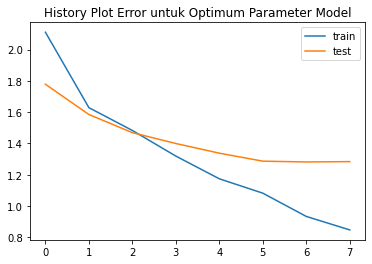

In [82]:
## Plot Training History
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model')
plt.legend()
plt.show()

#### 6.
Gunakan _pre-trained_ model yg telah dibuat tersebut untuk diimplementasikan pada dataset $\text{CIFAR 100}$ untuk kelas $1$ hingga kelas $10$ (masing-masing kelas terdiri dari
$100$ citra) dengan rasio _data train_ dan _data test_ sebanyak $60\% : 40\%$. Kemudian hitung matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specifity}$, dan $f_{1}\text{ score}$) dari _data train_ dan _data test_.

##### Load Data CIFAR 100

In [83]:
x_100, y_100 = load_dataset_cifar100()
x_100.shape

(60000, 32, 32, 3)

##### Mengambil Dataset Sebanyak 100 Per Kelasnya

In [190]:
idx_sample_100 = np.array([],dtype=int)

for i in range(10):
    idx = (y == i).reshape(x.shape[0])
    idx_data = np.where(idx == True)
    sampled_list = np.random.choice(idx_data[0], size=100, replace=False)
    idx_sample_100 = np.concatenate((idx_sample_100, sampled_list), axis=0)

##### Melakukan Validasi Apakah Shape-nya Sudah Valid atau Belum

In [193]:
x_sample_100 = x[idx_sample_100]
y_sample_100 = y[idx_sample_100]
x_sample_100.shape, y_sample_100.shape

((1000, 32, 32, 3), (1000, 1))

##### Melakukan Normalisasi untuk $x$

In [194]:
x_sample_100 = normalize(x_sample_100)

##### Merubah Menjadi Matrix Binary untuk $y$

In [195]:
y_sample_100 = tf.keras.utils.to_categorical(y_sample_100)

##### Memecah Menjadi 60 : 40 ~ Train : Test

In [196]:
x_train_100, x_test_100, y_train_100, y_test_100 = train_test_split(x_sample_100, y_sample_100, test_size=0.4)

##### Melakukan Evaluasi Pre-Trained Model dari Train Sebelumnya

In [197]:
pre_trained_model = load_model('checkpoint_model.h5', compile=True, custom_objects={
    "recall": recall,
    "specificity": specificity,
    "f1_score": f1_score
})
compare_train_and_test(pre_trained_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.573333,0.444079,0.974903,0.530519
Data Test,0.550000,0.456731,0.975160,0.541458


#### 7.
Buat arsitektur $\text{Convolutional Neural Network}$ yang baru dengan menggunakan semua _hidden layer pre-trained_ dari model sebelumnya, lakukan _freezing_ pada semua _hidden layer_ tersebut, lalu ganti _layer output_ $\text{softmax}$ dengan layer baru.

In [198]:
## Fungsi untuk melakukan freeze pada layer
def make_freeze(layer):
    layer.trainable = False
    return layer

## Melakukan copy untuk semua layer
copy_layers = [make_freeze(layer) for layer in pre_trained_model.layers]

## Me-replace ouput layer dengan layer baru dan trainable
copy_layers[-1] = Dense(10, activation=tf.nn.softmax)

## Membangun Model
new_cnn_model = create_model(0.0025, copy_layers)

#### 8.
Implementasikan model poin $(7)$ pada dataset $\text{CIFAR 100}$ untuk kelas $1$ hingga kelas $10$ dengan rasio _data train_ dan _data test_ sebanyak $60\% : 40\%$. Kemudian hitung matrik evaluasi ($\text{accuration}$, $\text{sensitivity}$, $\text{specificity}$, dan $f_{1}\text{ score}$) dari _data train_ dan _data test_.

##### Melakukan Train pada Model CNN Baru

In [199]:
## Mendefinisikan Early Stopping untuk Semua Model CNN Checkpoint dan Seterusnya
## Menambah Parameter Patience karena Data Training Lebih Sedikit Sehingga Tidak Terlalu Masalah untuk Melakukan Iterasi Epoch Lebih Banyak Karena Proses Train Akan 100 kali Lebih Cepat dibandingkan Sebelumnya 
new_es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

In [200]:
checkpoint = ModelCheckpoint("checkpoint_new_cnn_model.h5", monitor='loss', verbose=0, mode='auto', save_freq=1)

## Menurunkan jumlah batch seiring dengan berkurangnya jumlah data train
new_cnn_model_history = new_cnn_model.fit(x_train_100, y_train_100, epochs=100, batch_size=25, validation_data=(x_test_100, y_test_100), use_multiprocessing=True, callbacks=[new_es, checkpoint], verbose=1)

Epoch 1/100
24/24 [==============================] - 1s 57ms/step - loss: 3.3672 - accuracy: 0.1233 - recall: 0.0167 - specificity: 0.9744 - f1_score: 0.0263 - val_loss: 2.8560 - val_accuracy: 0.1675 - val_recall: 0.0150 - val_specificity: 0.9911 - val_f1_score: 0.0268
Epoch 2/100
24/24 [==============================] - 1s 45ms/step - loss: 2.4733 - accuracy: 0.2033 - recall: 0.0350 - specificity: 0.9911 - f1_score: 0.0616 - val_loss: 2.2938 - val_accuracy: 0.2475 - val_recall: 0.0325 - val_specificity: 0.9925 - val_f1_score: 0.0581
Epoch 3/100
24/24 [==============================] - 1s 47ms/step - loss: 2.0104 - accuracy: 0.2883 - recall: 0.0583 - specificity: 0.9911 - f1_score: 0.1005 - val_loss: 1.9557 - val_accuracy: 0.3025 - val_recall: 0.0725 - val_specificity: 0.9925 - val_f1_score: 0.1254
Epoch 4/100
24/24 [==============================] - 1s 46ms/step - loss: 1.7307 - accuracy: 0.3550 - recall: 0.0750 - specificity: 0.9924 - f1_score: 0.1269 - val_loss: 1.7309 - val_accurac

##### Menghitung Matrik Evaluasi Model CNN Baru

In [201]:
compare_train_and_test(new_cnn_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.611667,0.397478,0.986659,0.517939
Data Test,0.567500,0.391827,0.985844,0.511378


##### Melakukan _Plotting Error_

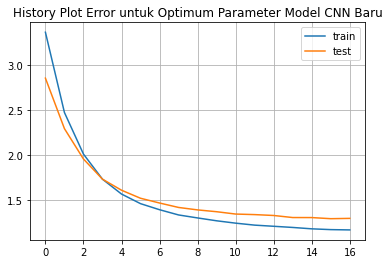

In [202]:
## Plot Training History
plt.plot(new_cnn_model_history.history['loss'], label='train')
plt.plot(new_cnn_model_history.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model CNN Baru')
plt.grid()
plt.legend()
plt.show()

#### 9.
Lalu lakukan _unfreeze_ pada satu _hidden layer_ ($\text{conv-pool-actv}$) paling atas dan lakukan kembali proses training menggunakan deskripsi data yang sama dengan poin $(8)$. Bagaimana hasil yang diperoleh dari perubahan ini?

##### Melakukan _unfreeze_ pada satu _hidden layer_ paling atas

In [203]:
## Disclaimer: Asumsi model-nya sama dengan (8)
## Melakukan unfreeze pada hidden layer paling atas
new_cnn_model.layers[0].trainable = True

##### Melanjutkan Proses Train

In [204]:
checkpoint = ModelCheckpoint("checkpoint_new_cnn_model_phase_2.h5", monitor='loss', verbose=0, mode='auto', save_freq=1)
new_cnn_model_history_phase_2 = new_cnn_model.fit(x_train_100, y_train_100, epochs=100, batch_size=25, validation_data=(x_test_100, y_test_100), use_multiprocessing=True, callbacks=[new_es, checkpoint])

Epoch 1/100
24/24 [==============================] - 1s 46ms/step - loss: 1.1595 - accuracy: 0.6033 - recall: 0.4017 - specificity: 0.9856 - f1_score: 0.5201 - val_loss: 1.2792 - val_accuracy: 0.5850 - val_recall: 0.3900 - val_specificity: 0.9861 - val_f1_score: 0.5106
Epoch 2/100
24/24 [==============================] - 1s 44ms/step - loss: 1.1536 - accuracy: 0.6083 - recall: 0.3917 - specificity: 0.9863 - f1_score: 0.5130 - val_loss: 1.2835 - val_accuracy: 0.5825 - val_recall: 0.4000 - val_specificity: 0.9836 - val_f1_score: 0.5140
Epoch 00002: early stopping


##### Menghitung Matrik Evaluasi Model CNN Baru Phase 2

In [205]:
compare_train_and_test(new_cnn_model, x_train_100, y_train_100, x_test_100, y_test_100)

,Accuracy,Sensitivity,Specificity,F1 Score
Data Train,0.6150,0.417215,0.987268,0.539685
Data Test,0.5825,0.394231,0.983440,0.507157


##### Melakukan _Plotting Error Phase 2_

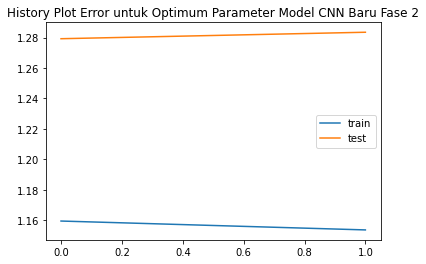

In [206]:
## Plot Training History
plt.plot(new_cnn_model_history_phase_2.history['loss'], label='train')
plt.plot(new_cnn_model_history_phase_2.history['val_loss'], label='test')
plt.title('History Plot Error untuk Optimum Parameter Model CNN Baru Fase 2')
plt.legend()
plt.show()

##### Laporan Hasil

Berdasarkan hasil train yang terakhir, melakukan _unfreeze_ pada layer paling depat tidak memberikan perubahan hasil metrik yang _significant_ dan cenderung sama dengan hasil saat semua layer kecuali _output layer_ di-_freeze_. Hal ini menunjukkan bahwa pembobotan _node_ sudah konvergen bahkan pada saat pertama kali _model_ ini di-_load_ dari _pre-trained_ model yang sudah dijalankan sebelumnya. Bahkan ketika _output layer_-nya di-inisialisasi ulang, hasil pembobotan setelah training menggunakan data $\text{CIFAR 100}$ menghasilkan akurasi yang cenderung sama dengan hasil pembobotan dengan training menggunakan data $\text{CIFAR 10}$.

#### 10.
Tuliskan analisis anda terkait implementasi menggunakan **Transfer Learning**.

- Karena dataset $\text{CIFAR 10}$ dan $\text{CIFAR 100}$ untuk kelas $1 - 10$ cenderung sama, memungkinkan bahwa melatih menggunakan kedua data tersebut dan melakukan uji menggunakan kedua data tersebut akan menghasilkan akurasi yang mirip untuk setiap jenis dataset.
- Karena dataset $\text{CIFAR 10}$ dan $\text{CIFAR 100}$ untuk kelas $1 - 10$ cenderung sama pula, pada saat melakukan _transfer learning_ dari satu dataset ke dataset lainnya, pembobotan akan konvergen di akurasi yang cenderung sama pula. Bahkan apabila kita melakukan inisialisasi ulang pembobotan simpul pada _output layer_, pembobotan simpul pada _output layer_ akan menghasilkan model yang memiliki akurasi sebelum dilakukan pembobotan ulang simpul pada _output layer_.
- Model yang sudah konvergen, apabila _hidden layer_ di-_freeze_ ataupun tidak di-_freeze_ tidak memberikan dampak signifikan dalam memberikan hasil evaluasi. Bahkan model yang sudah konvergen kemudian dilatih kembali menggunakan dataset yang mirip akan konvergen dalam beberapa _epoch_ saja pada saat melakukan _transfer learning_.